## Identifying and Visualising all the players that passed the ball into the box (inplay only) during the World Cup 2022

In [1]:
%matplotlib inline

In [2]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsbombpy import sb
from mplsoccer import Pitch, Sbopen, VerticalPitch

In [3]:
#declare mplsoccer parser
parser = Sbopen()

In [4]:
# getting the df of the 64 matches played in the WC
wc22=sb.matches(competition_id=43,season_id=106)

In [5]:
# list of match_ids in the wc
match_ids = wc22['match_id'].to_list()

In [6]:
# defining the length of the pitch and penalty box
pitch_length = 120
pitch_width = 80
penalty_area_length = 16
penalty_area_width = 40

### Iterating through the 64 matches

In [8]:
#declare an empty dataframe
danger_passes = pd.DataFrame()
for idx in match_ids:
    #open the event data from this game
    df = parser.event(idx)[0]
    # filter for in-play passes
    passes = df.loc[df['type_name']=='Pass'].loc[df['sub_type_name']!='Throw-in'].loc[df['sub_type_name']!='Free Kick'].loc[df['sub_type_name']!='Corner'].set_index('id')
    # Taking relevant columns
    passes=passes[['x','y','end_x','end_y','type_name','player_name']]
    # passes originating from outside the box
    outside = passes[((passes['x'] >= 0) & (passes['x'] <= pitch_length)) & ((passes['y'] >= 0) & (passes['y'] <= pitch_width)) & ~(((passes['x'] >= ((pitch_length - penalty_area_length)/2)) & (passes['x'] <= ((pitch_length + penalty_area_length)/2))) & ((passes['y'] >= 0) & (passes['y'] <= penalty_area_width)))]
    # passes ending inside the box
    inside=passes[(passes['end_x']>=104) & (passes['end_x']<=120) & (passes['end_y']>=21) & (passes['end_y']<=60)]
    # merge to get pass that starts outside and ends inside only
    merged_df = pd.merge(outside, inside, how='inner')
    
    #concatenate dataframe with a previous one to keep danger passes from the whole tournament
    danger_passes = pd.concat([danger_passes, merged_df])

### Sorting according to who passed more frequently into the box

In [9]:
# count the number of occurrences of each name
names = danger_passes['player_name'].value_counts()

# sort the names based on the number of occurrences
sorted_names = names.index.tolist()

# rearrange the dataframe based on the sorted names
danger_passes = danger_passes.loc[danger_passes['player_name'].isin(sorted_names), :]
danger_passes['player_name'] = pd.Categorical(danger_passes['player_name'], categories=sorted_names, ordered=True)
danger_passes = danger_passes.sort_values('player_name')

### Making the plot of the best 12 players

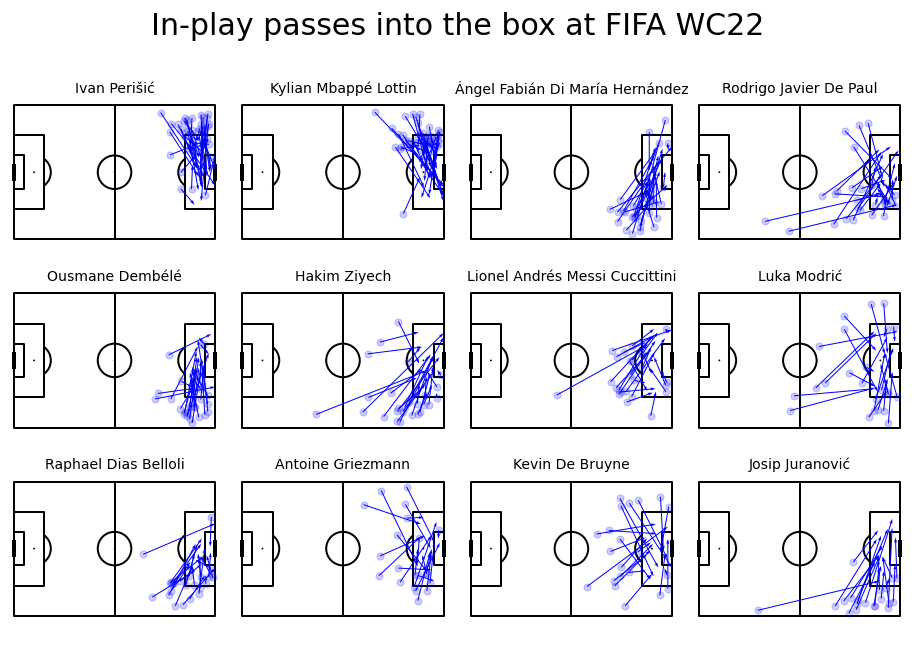

In [10]:
#get the list of all players who made a pass
names = danger_passes['player_name'].unique()

#draw 4x3 pitches
pitch = Pitch(line_color='black', pad_top=20)
fig, axs = pitch.grid(ncols = 4, nrows = 3, grid_height=0.85, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0.04, endnote_space=0.01)

#for each player
for name, ax in zip(names, axs['pitch'].flat[:len(names)]):
    #put player name over the plot
    ax.text(60, -10, name,ha='center', va='center', fontsize=14)
    #take only passes by this player
    player_df = danger_passes.loc[danger_passes["player_name"] == name]
    #scatter
    pitch.scatter(player_df.x, player_df.y, alpha = 0.2, s = 50, color = "blue", ax=ax)
    #plot arrow
    pitch.arrows(player_df.x, player_df.y,player_df.end_x, player_df.end_y, color = "blue", ax=ax, width=1)
    
    
#Another way to set title using mplsoccer 
axs['title'].text(0.5, 0.5, 'In-play passes into the box at FIFA WC22', ha='center', va='center', fontsize=30)
plt.savefig("plot_wc22_passers",bbox_figure="tight",dpi=300)
plt.show()

### To view the data in a horizontal bar chart

In [12]:
names = danger_passes['player_name'].value_counts()

In [13]:
ballers = names.to_frame().reset_index()
ballers = ballers.rename(columns={"index": "player_name", "player_name":"danger_passes"})
ballers = ballers.sort_values(by='danger_passes', ascending=True)
ballers=ballers.tail(12)

In [14]:
# Using the player's well known names
names=["Juranovic","De Bruyne","Griezmann","Raphinha","Modric","Messi","Ziyech","Dembele","De Paul","Di Maria","Mbappe","Perisic"]
ballers["short_names"] = names

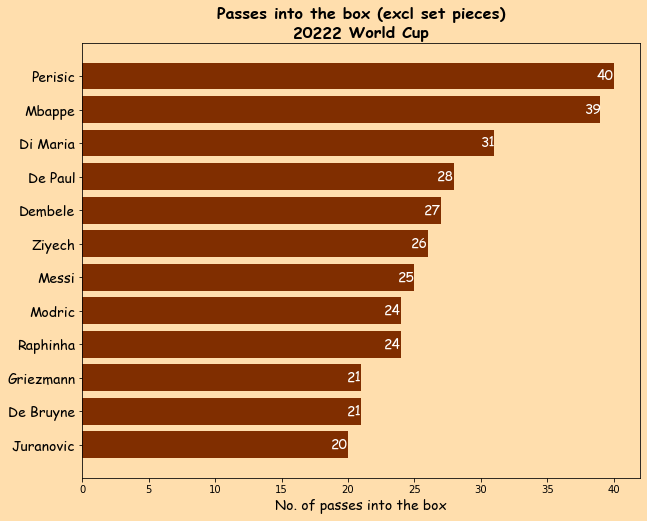

In [15]:
# create horizontal bar chart
fig, ax = plt.subplots(figsize=(10,8), facecolor='navajowhite')
plt.gca().set_facecolor('navajowhite')
bars = ax.barh(ballers['short_names'], ballers['danger_passes'], color='#802E00')

# add age values inside the bars
for bar in bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
            str(int(bar.get_width())),
            ha='right', va='center', color='white',fontdict={'fontsize':14,'fontfamily':'Comic Sans MS'})

ax.set_xlabel('No. of passes into the box', fontdict={'fontsize':14,'fontfamily':'Comic Sans MS'})
ax.tick_params(axis='y', labelsize=14)
ax.set_yticklabels(ballers['short_names'], fontname='Comic Sans MS', fontsize=14)
ax.set_title("Passes into the box (excl set pieces)\n20222 World Cup", fontdict={'fontsize':16, 'fontweight':'bold', 'fontfamily':'Comic Sans MS'})

plt.savefig("wc22_passers",bbox_figure="tight",dpi=300)
plt.show()